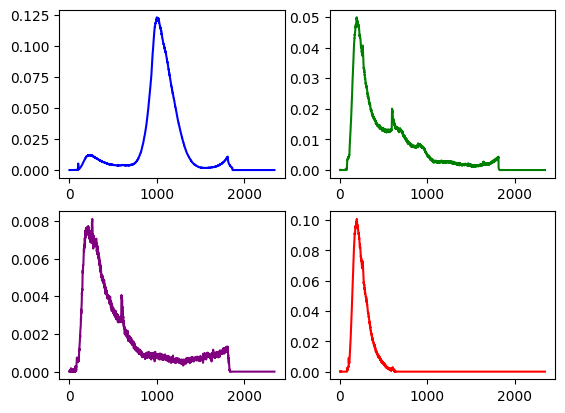

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pybeads

# CSVファイルを読み込み、最終行を除去
data = pd.read_csv('SWNT.csv', skipfooter=1, engine='python')

# Figureオブジェクトを作成
fig = plt.figure()
# Axesオブジェクトを作成
# 1つのFigureに複数のAxesを作成
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# プロットするデータ
x = data['Temp.']
H2 = data['H2']
CO = data['CO']
CO2 = data['CO2']
H2O = data['H2O']

# プロット
ax1.plot(x, H2, 'b')
ax2.plot(x, CO, 'g')
ax3.plot(x, CO2, 'purple')
ax4.plot(x, H2O, 'r')

# プロットの表示
plt.show()

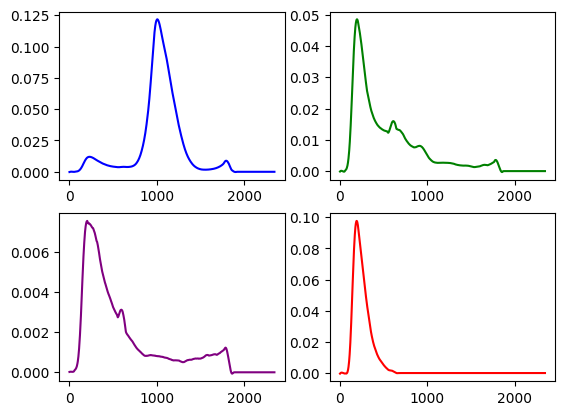

In [2]:
# H2, CO, CO2, H2Oシグナルを平滑化（Savitzky-Golayフィルタ使用）

smoothed_data = {
    'H2': savgol_filter(data['H2'], window_length=101, polyorder=3),
    'H2O': savgol_filter(data['H2O'], window_length=101, polyorder=3),
    'CO': savgol_filter(data['CO'], window_length=101, polyorder=3),
    'CO2': savgol_filter(data['CO2'], window_length=101, polyorder=3)
}
#Figureオブジェクトを作成
fig = plt.figure()
#Axesオブジェクトを作成
#1つのFigureに複数のAxesを作成
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
#プロットするデータ
x = data['Temp.']
H2 = smoothed_data['H2']
CO = smoothed_data['CO']
CO2 = smoothed_data['CO2']
H2O = smoothed_data['H2O']

#プロット
ax1.plot(x, H2, 'b')
ax2.plot(x, CO, 'g')
ax3.plot(x, CO2, 'purple')
ax4.plot(x, H2O, 'r')

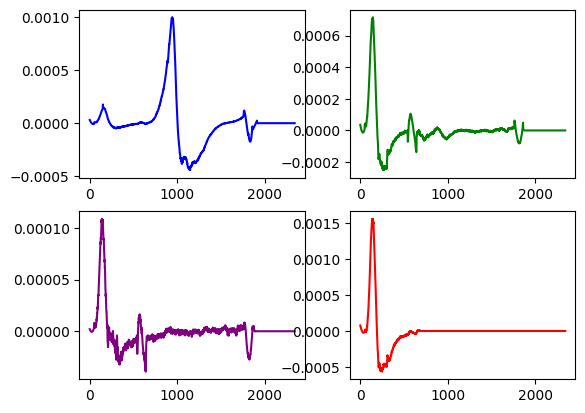

In [3]:
# 各ガスシグナルの微分を計算
derivatives = {
    'H2': np.gradient(smoothed_data['H2'], data['Temp.']),
    'H2O': np.gradient(smoothed_data['H2O'], data['Temp.']),
    'CO': np.gradient(smoothed_data['CO'], data['Temp.']),
    'CO2': np.gradient(smoothed_data['CO2'], data['Temp.'])
}

#Figureオブジェクトを作成
fig = plt.figure()
#Axesオブジェクトを作成
#1つのFigureに複数のAxesを作成
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
#プロットするデータ
x = data['Temp.']
H2 = derivatives['H2']
CO = derivatives['CO']
CO2 = derivatives['CO2']
H2O = derivatives['H2O']

#プロット
ax1.plot(x, H2, 'b')
ax2.plot(x, CO, 'g')
ax3.plot(x, CO2, 'purple')
ax4.plot(x, H2O, 'r')

# ゼロ交差点を格納する辞書
zero_crossing_indices = {}

# 各ガスについてループを回して、微分が0に近い箇所を探す
for gas in ['H2', 'H2O', 'CO', 'CO2']:
    zero_crossing_indices[gas] = np.where(np.abs(derivatives[gas]) < 0.0001)[0]


In [4]:
# ピーク特性を格納する辞書を作成
peak_properties = {}

for gas in ['H2', 'H2O', 'CO', 'CO2']:
    signal = smoothed_data[gas]
    temperature = data['Temp.']

    # ゼロ交差点の中で最大のy値を持つインデックスを特定
    peak_index = np.argmax(signal[zero_crossing_indices[gas]])
    peak_temperature = zero_crossing_indices[gas][peak_index]
    peak_intensity = signal[peak_temperature]
    
    # 半値を計算し、FWHMの両端を探す
    half_max = peak_intensity / 2
    left_idx = np.where(signal[:peak_temperature] < half_max)[0]
    right_idx = np.where(signal[peak_temperature:] < half_max)[0]

    # FWHMに基づいた開始温度と終了温度の特定
    start_temp = temperature[left_idx[-1]] if left_idx.size > 0 else temperature[0]
    end_temp = temperature[peak_temperature + right_idx[0]] if right_idx.size > 0 else temperature[-1]

    # 対称性の計算
    symmetry = abs((peak_temperature - start_temp) - (end_temp - peak_temperature))
    
    # 特性を辞書に格納
    peak_properties[gas] = {
        "Peak Temperature": peak_temperature,
        "Peak Intensity": peak_intensity,
        "Start Temperature": start_temp,
        "End Temperature": end_temp,
        "FWHM": end_temp - start_temp,
        "Symmetry": symmetry
    }

# 結果を表示
peak_properties_df = pd.DataFrame(peak_properties).T
print(peak_properties_df)


     Peak Temperature  Peak Intensity  Start Temperature  End Temperature  \
H2             1004.0        0.121760              917.0           1185.0   
H2O             190.0        0.097691              139.0            299.0   
CO              194.0        0.048575              137.0            321.0   
CO2             203.0        0.007553              141.0            459.0   

      FWHM  Symmetry  
H2   268.0      94.0  
H2O  160.0      58.0  
CO   184.0      70.0  
CO2  318.0     194.0  
